In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kapillondhe/american-sign-language")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/american-sign-language


In [ ]:
import os
import sys
import torch
import cv2
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from torch.nn.utils.rnn import pad_sequence

In [ ]:
def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    print('\r' + str_, end='')

In [ ]:
data_dir = path + '/ASL_Dataset/Train'

subdirs = [d for d in os.listdir(data_dir)
           if os.path.isdir(os.path.join(data_dir, d))]
print("Subdirectories (should be one per label):", subdirs)

Subdirectories (should be one per label): ['N', 'R', 'Space', 'B', 'I', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'Nothing', 'J']


In [ ]:
class ASLImageFolder(Dataset):
    """
    Very much like torchvision.datasets.ImageFolder,
    but based on cv2 so you can mirror your real-time code exactly.
    """
    def __init__(self, root_dir, img_size=(224,224), normalize=True):
        self.root_dir = root_dir
        self.img_size = img_size

        # build list of (path, label_idx)
        classes = sorted(
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        )
        self.class_to_idx = {cls:i for i,cls in enumerate(classes)}

        self.samples = []
        for cls in classes:
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png','.jpg','.jpeg')):
                    self.samples.append((os.path.join(cls_dir, fname),
                                         self.class_to_idx[cls]))

        # transforms: resize, center-crop, to‐tensor, normalize (if you used that)
        tfms = [
            transforms.ToPILImage(),
            transforms.Resize(self.img_size),
            transforms.CenterCrop(self.img_size),
            transforms.ToTensor()
        ]
        if normalize:
            tfms.append(transforms.Normalize(mean=[0.485,0.456,0.406],
                                             std =[0.229,0.224,0.225]))
        self.transform = transforms.Compose(tfms)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        # load with cv2 to match your real-time code
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        return img, label

# ——— Usage ———

data_dir = path + '/ASL_Dataset/Train'     # point at the folder holding 0/,1/,…A/,B/
batch_size = 32

# instantiate
dataset = ASLImageFolder(data_dir, img_size=(224,224), normalize=True)
class_names = sorted(
    dataset.class_to_idx,
    key=lambda k: dataset.class_to_idx[k]
)
num_classes = len(class_names)

# split indices
from sklearn.model_selection import train_test_split
idx = list(range(len(dataset)))
train_idx, test_idx = train_test_split(
    idx, test_size=0.2,
    stratify=[label for _, label in dataset.samples],
    random_state=42
)

# create subsets & loaders
from torch.utils.data import Subset
train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    Subset(dataset, test_idx),
    batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
)

class_names = sorted(dataset.class_to_idx, key=lambda k: dataset.class_to_idx[k])
print("Classes:", class_names)
print("Number of classes:", num_classes)
print("Number of training samples:", len(train_loader.dataset))
print("Number of test samples:", len(test_loader.dataset))

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 28
Number of training samples: 132536
Number of test samples: 33134


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def one_hot_encode_labels(y_train, y_test, num_classes):
    y_train_enc = nn.functional.one_hot(y_train, num_classes=num_classes).float()
    y_test_enc = nn.functional.one_hot(y_test, num_classes=num_classes).float()
    return y_train_enc, y_test_enc

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes, img_size=(224,224)):
        super().__init__()
        c, h, w = 3, *img_size
        self.features = nn.Sequential(
            nn.Conv2d(c, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25),
        )
        with torch.no_grad():
            dummy = torch.zeros(1, c, h, w)
            n_feats = self.features(dummy).numel()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_feats, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
def train_cnn_model(model, train_loader, test_loader, device,
                    epochs=10, lr=1e-3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []

    for epoch in range(1, epochs+1):
        # ——— TRAINING ———
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        for batch_idx, (imgs, labels) in enumerate(train_loader, start=1):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss    += loss.item() * imgs.size(0)
            preds            = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            running_total   += labels.size(0)

            # print per‐batch progress
            print_line(f"[Epoch {epoch}/{epochs}] "
                       f"Train batch {batch_idx}/{len(train_loader)} "
                       f"loss={loss.item():.4f}")

        # finish training line
        print()

        train_loss = running_loss / running_total
        train_acc  = running_correct / running_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)


        # ——— VALIDATION ———
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_idx, (imgs, labels) in enumerate(test_loader, start=1):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss    += loss.item() * imgs.size(0)
                preds        = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total   += labels.size(0)

                # print per‐batch progress
                print_line(f"[Epoch {epoch}/{epochs}] "
                           f"Val batch {batch_idx}/{len(test_loader)} "
                           f"loss={loss.item():.4f}")

        # finish validation line
        print()

        val_loss = val_loss / val_total
        val_acc  = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # final epoch summary
        print(f"[Epoch {epoch}/{epochs}] "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    return model, {
        'train_loss': train_losses,
        'train_acc':  train_accs,
        'val_loss':   val_losses,
        'val_acc':    val_accs
    }


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNClassifier(num_classes, img_size=(224, 224)).to(device)
model, history = train_cnn_model(
    model,
    train_loader,
    test_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=10,
    lr=1e-3
)

[Epoch 1/10] Train batch 4142/4142 loss=3.0901
[Epoch 1/10] Val batch 1036/1036 loss=2.7604
[Epoch 1/10] train_loss=3.1184, train_acc=0.0791 | val_loss=2.7253, val_acc=0.1883
[Epoch 2/10] Train batch 4142/4142 loss=1.7746
[Epoch 2/10] Val batch 1036/1036 loss=0.7199
[Epoch 2/10] train_loss=2.3106, train_acc=0.2520 | val_loss=0.7383, val_acc=0.8100
[Epoch 3/10] Train batch 4142/4142 loss=0.9708
[Epoch 3/10] Val batch 1036/1036 loss=0.1654
[Epoch 3/10] train_loss=1.2937, train_acc=0.5229 | val_loss=0.2803, val_acc=0.9379
[Epoch 4/10] Train batch 4142/4142 loss=0.9105
[Epoch 4/10] Val batch 1036/1036 loss=0.0830
[Epoch 4/10] train_loss=0.9971, train_acc=0.6335 | val_loss=0.1886, val_acc=0.9641
[Epoch 5/10] Train batch 4142/4142 loss=0.6360
[Epoch 5/10] Val batch 1036/1036 loss=0.0351
[Epoch 5/10] train_loss=0.8386, train_acc=0.6970 | val_loss=0.0904, val_acc=0.9919
[Epoch 6/10] Train batch 4142/4142 loss=0.6526
[Epoch 6/10] Val batch 1036/1036 loss=0.0322
[Epoch 6/10] train_loss=0.7167, t

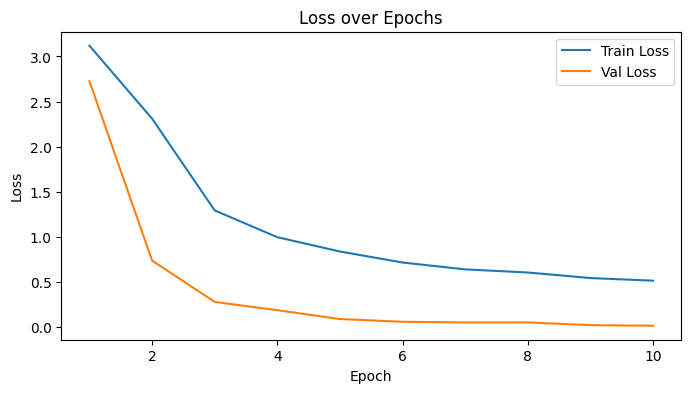

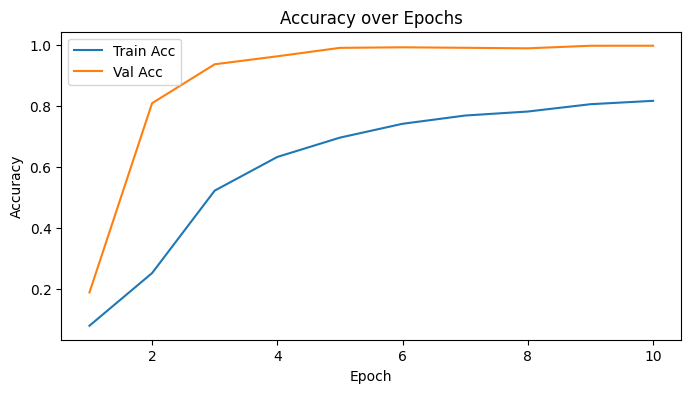

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

import matplotlib.pyplot as plt

# Loss curves
plt.figure(figsize=(8,4))
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curves
plt.figure(figsize=(8,4))
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
PATH = "cnn_asl_model.pth"
torch.save(model.state_dict(), PATH)
print(f"Saved model weights to {PATH}")

Saved model weights to cnn_asl_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


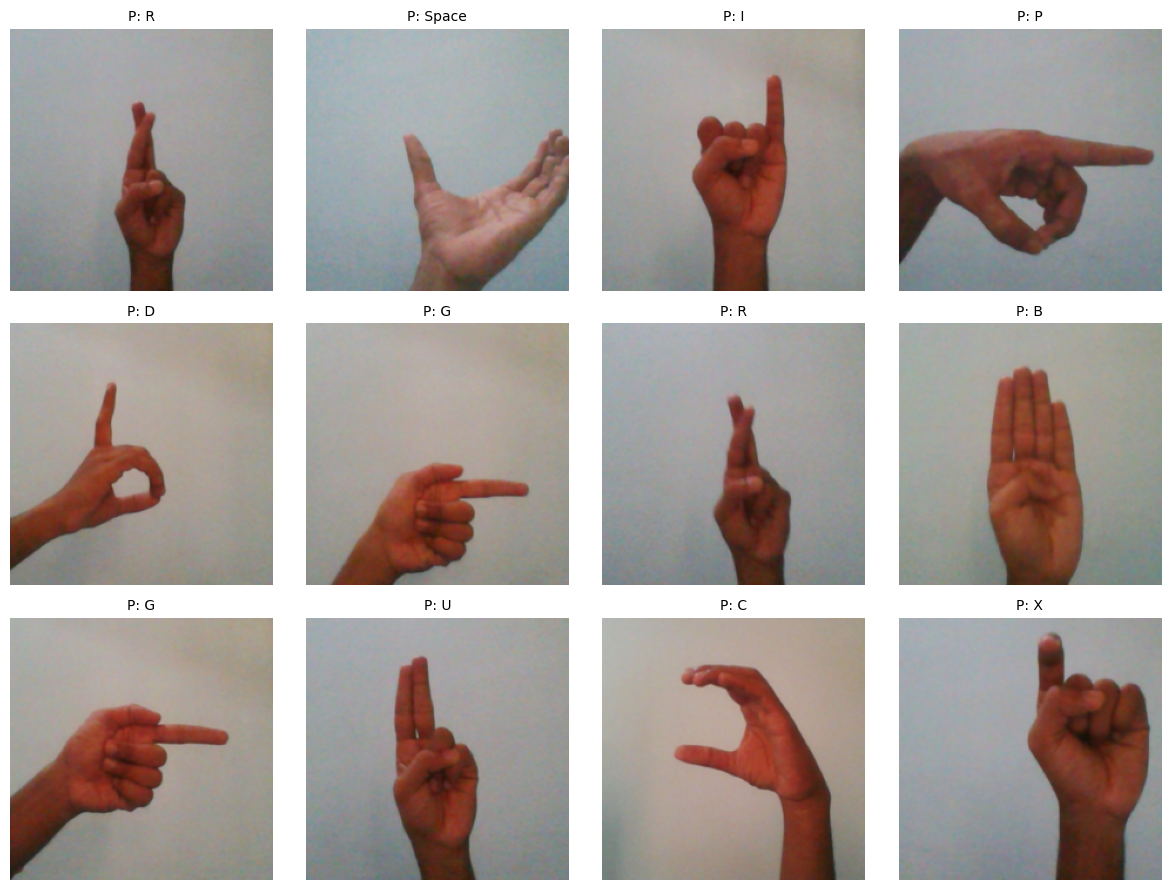

In [ ]:
import matplotlib.pyplot as plt

def imshow(img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    img = img_tensor.cpu().clone()                              # clone to not modify original
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)                                       # unnormalize
    img = img.permute(1, 2, 0).numpy()                          # C×H×W → H×W×C
    plt.imshow(img)
    plt.axis('off')

def visualize_predictions(model, loader, classes, device, num_images=8):
    """
    Show `num_images` from `loader` along with the model's predictions.

    Args:
        model      : your trained CNN
        loader     : a DataLoader (usually test_loader)
        classes    : list of class names
        device     : 'cuda' or 'cpu'
        num_images : total images to show
    """
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, num_images//4 * 3))

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)                   # (B, C)
            preds   = outputs.argmax(dim=1)         # (B,)

            for i in range(imgs.size(0)):
                if images_shown >= num_images:
                    break

                plt.subplot(num_images//4, 4, images_shown+1)
                imshow(imgs[i])
                title = f"P: {classes[preds[i].item()]}"
                # optional: also show true label
                # title += f"\nT: {classes[labels[i].item()]}"
                plt.title(title, fontsize=10)
                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()


visualize_predictions(model, test_loader, class_names, device, num_images=12)

In [ ]:
class SequenceModel(nn.Module):
    def __init__(self, cnn_encoder: nn.Module, cnn_output_dim: int,
                 rnn_hidden_size: int, num_layers: int, num_classes: int):
        super().__init__()
        self.cnn_encoder = cnn_encoder
        self.rnn = nn.LSTM(input_size=cnn_output_dim, hidden_size=rnn_hidden_size,
                           num_layers=num_layers, batch_first=True,
                           bidirectional=True)
        self.fc = nn.Linear(rnn_hidden_size*2, num_classes)
    def forward(self, x):
        b, s, C, H, W = x.size()
        x = x.view(b*s, C, H, W)
        feats = self.cnn_encoder(x)
        feats = feats.view(b, s, -1)
        outs, _ = self.rnn(feats)
        outs = self.fc(outs)
        return outs

def build_sequence_model(cnn_model, img_size, rnn_hidden_size, num_layers, num_classes, device='cpu'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_feat = nn.Sequential(cnn_model.features, nn.Flatten())
    dummy = torch.zeros(1, 3, *img_size)
    feat_dim = cnn_feat(dummy).size(1)
    model = SequenceModel(cnn_feat, feat_dim, rnn_hidden_size, num_layers, num_classes).to(device)
    return model

In [ ]:
def collate_fn(batch):
    seqs, labs = zip(*batch)
    seq_lengths = [s.size(0) for s in seqs]
    padded_seqs = pad_sequence(seqs, batch_first=True)            # (B, T_max, feat)
    padded_labs = pad_sequence(labs,  batch_first=True,
                               padding_value=-100)                # for ignore_index
    return padded_seqs, padded_labs

In [ ]:
def train_rnn_model(model, train_loader, test_loader, device,
                    epochs=10, lr=1e-3):
    model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(epochs):
        # ——— TRAINING ———
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_tokens = 0

        for seqs, labs in train_loader:
            seqs, labs = seqs.to(device), labs.to(device)
            optimizer.zero_grad()
            outputs = model(seqs)                         # (B, T, C)
            B, T, C = outputs.shape

            outputs_flat = outputs.view(-1, C)           # (B*T, C)
            labs_flat    = labs.view(-1)                 # (B*T,)
            loss = criterion(outputs_flat, labs_flat)
            loss.backward()
            optimizer.step()

            # accumulate stats
            mask = labs_flat.ne(-100)
            running_loss    += loss.item() * mask.sum().item()
            preds_flat       = outputs_flat.argmax(1)
            running_correct += (preds_flat[mask] == labs_flat[mask]).sum().item()
            running_tokens  += mask.sum().item()

        train_loss = running_loss / running_tokens
        train_acc  = running_correct / running_tokens

        # ——— VALIDATION ———
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_tokens = 0
        with torch.no_grad():
            for seqs, labs in test_loader:
                seqs, labs = seqs.to(device), labs.to(device)
                outputs = model(seqs)
                B, T, C = outputs.shape

                outputs_flat = outputs.view(-1, C)
                labs_flat    = labs.view(-1)
                loss = criterion(outputs_flat, labs_flat)

                mask = labs_flat.ne(-100)
                val_loss    += loss.item() * mask.sum().item()
                preds_flat   = outputs_flat.argmax(1)
                val_correct += (preds_flat[mask] == labs_flat[mask]).sum().item()
                val_tokens  += mask.sum().item()

        val_loss /= val_tokens
        val_acc   = val_correct / val_tokens

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | "
              f"train_loss {train_loss:.4f}, train_acc {train_acc:.4f} | "
              f"val_loss {val_loss:.4f}, val_acc {val_acc:.4f}")

    return model

In [ ]:
model = build_sequence_model(model, (224,224), rnn_hidden_size=128, num_layers=2, num_classes=num_classes)
model = train_rnn_model(model, train_loader, test_loader, device,
                        epochs=10, lr=1e-3)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor